# 1. Stereo-seq Olfactory bulb

Here, we analyzed the mouse olfactory bulb data generated from Stereo-seq. The raw data was downloaded from https://github.com/JinmiaoChenLab/SEDR_analyses.

## Load data

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import SECE
import torch
import numpy as np
import scanpy as sc

result_path = 'olfactory_bulb'
os.makedirs(result_path, exist_ok=True)

In [2]:
adata = sc.read('./data/olfactory_bulb.h5ad')
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=20)
adata

AnnData object with n_obs × n_vars = 14325 × 17550
    obs: 'x', 'y', 'n_genes'
    var: 'n_cells'
    obsm: 'spatial'
    layers: 'counts'

## Creating and training the model

In [3]:
sece = SECE.SECE_model(adata.copy(), 
                       likelihood='zinb',
                       result_path=result_path,
                       dropout_rate=0.1,
                       dropout_gat_rate=0.2,
                       device='cuda:1')

Likelihood: zinb
Input dim: 17550
Latent Dir: 32
Model1 dropout: 0.1
Model2 dropout: 0.2


In [4]:
sece.adata.X.toarray() # Count matrix

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

### AE Module of SECE

In [5]:
# Prepare input data for AE module
sece.prepare_data(lib_size='explog', normalize=True, scale=False)

Library size: explog
Input normalize: True
Input scale: False
Hvg: False
(14325, 17550)


In [6]:
# train and predict for AE module
sece.train_model1(epoch1=50, plot=True)
adata1 = sece.predict_model1()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:02<00:00,  9.66s/it]


Model1 lr: 0.001
Model1 epoch: 50
Model1 batch_size: 128


### GAT Module of SECE

In [7]:
# Prepare input data for GAT module
sece.prepare_graph(cord_keys=['x','y'], 
                   latent_key = 'X_CE',
                   num_batch_x=2, 
                   num_batch_y=1, 
                   neigh_cal='knn',
                   n_neigh=10, 
                   kernal_thresh=0.5)

Batch 1: Each cell have 10.0 neighbors
Batch 1: Each cell have 16similar cells
Batch 2: Each cell have 10.0 neighbors
Batch 2: Each cell have 16similar cells
All: Each cell have 10.0 neighbors
Graph cal: knn
knn: 10
kernal_thresh: 0.5


In [8]:
# train and predict for GAT module
sece.train_model2(  lr_gat=0.01, 
                    weight_decay_gat=0, 
                    epoch2=40, 
                    re_weight=1, 
                    si_weight=0.08, 
                    plot=True)
adata1 = sece.predict_model2()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.41it/s]


Model2 lr: 0.01
Model2 epoch: 40
Model2 similar weight: 0.08


## Clustering

### Clustering for SE

In [9]:
sc.pp.neighbors(adata1, use_rep='X_SE', key_added='X_SE')
adata1.obsm['umap_SE'] = sc.tl.umap(adata1, neighbors_key='X_SE', copy=True).obsm['X_umap']
SECE.cluster_func(adata1, clustering='mclust', use_rep='X_SE', cluster_num=9, key_add='layer_cluster')

VSCode R Session Watcher requires jsonlite, rlang. Please install manually in order to use VSCode-R.
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 14325 × 17550
    obs: 'x', 'y', 'n_genes', 'size', 'n_counts', 'layer_cluster'
    var: 'n_cells'
    uns: 'log1p', 'X_SE'
    obsm: 'spatial', 'X_CE', 'X_SE', 'umap_SE'
    layers: 'counts', 'expr'
    obsp: 'X_SE_distances', 'X_SE_connectivities'

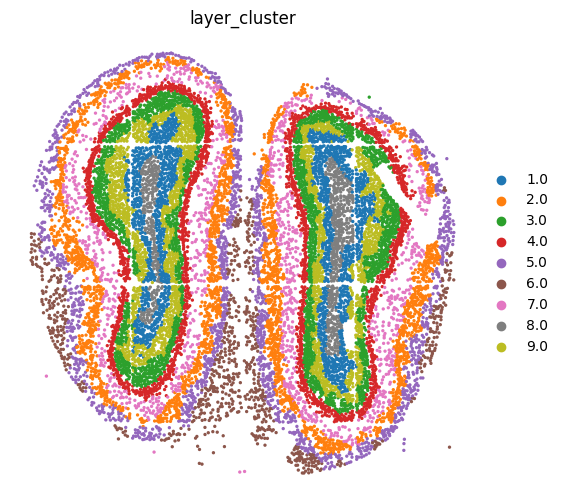

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (6,6)}):
    sc.pl.embedding(adata1, basis='spatial', color=['layer_cluster'],
                    frameon=False, show=False, s=23)

### Clustering for CE

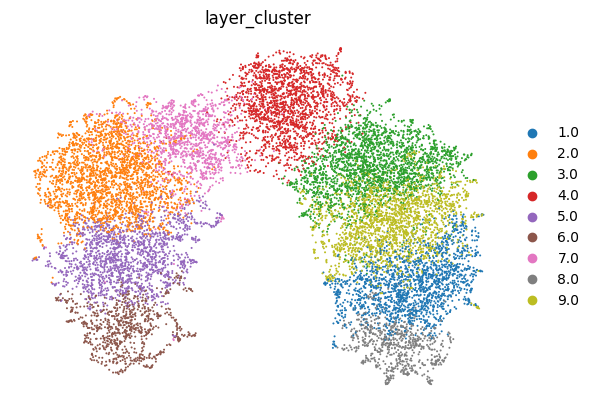

In [11]:
sc.pl.embedding(adata1, basis='umap_SE', color=['layer_cluster'], frameon=False)

In [12]:
sc.pp.neighbors(adata1, use_rep='X_CE', key_added='X_CE')
adata1.obsm['umap_CE'] = sc.tl.umap(adata1, neighbors_key='X_CE', copy=True).obsm['X_umap']
SECE.cluster_func(adata1, clustering='leiden', use_rep='X_CE', res=1.2, key_add='type_cluster')

AnnData object with n_obs × n_vars = 14325 × 17550
    obs: 'x', 'y', 'n_genes', 'size', 'n_counts', 'layer_cluster', 'type_cluster'
    var: 'n_cells'
    uns: 'log1p', 'X_SE', 'layer_cluster_colors', 'X_CE', 'type_cluster', 'leiden'
    obsm: 'spatial', 'X_CE', 'X_SE', 'umap_SE', 'umap_CE'
    layers: 'counts', 'expr'
    obsp: 'X_SE_distances', 'X_SE_connectivities', 'X_CE_distances', 'X_CE_connectivities', 'type_cluster_distances', 'type_cluster_connectivities'

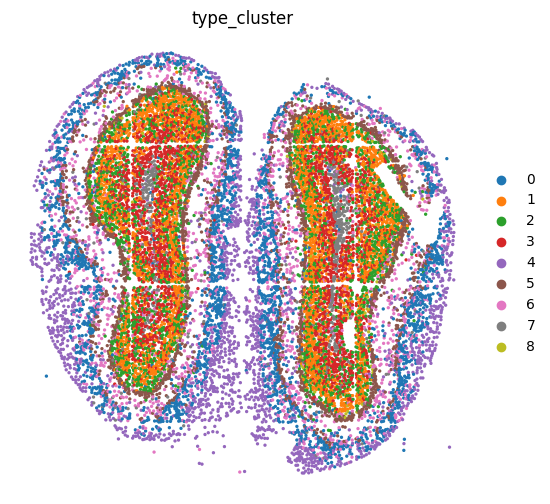

In [13]:
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.embedding(adata1, basis='spatial', color=['type_cluster'],
                    frameon=False, show=False, s=23)

<AxesSubplot: title={'center': 'type_cluster'}, xlabel='umap_CE1', ylabel='umap_CE2'>

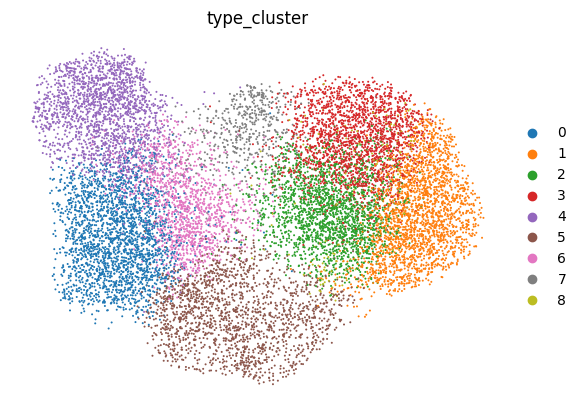

In [14]:
sc.pl.embedding(adata1, basis='umap_CE', color=['type_cluster'],
                frameon=False, ncols=3, show=False)

In [15]:
adata1

AnnData object with n_obs × n_vars = 14325 × 17550
    obs: 'x', 'y', 'n_genes', 'size', 'n_counts', 'layer_cluster', 'type_cluster'
    var: 'n_cells'
    uns: 'log1p', 'X_SE', 'layer_cluster_colors', 'X_CE', 'type_cluster', 'leiden', 'type_cluster_colors'
    obsm: 'spatial', 'X_CE', 'X_SE', 'umap_SE', 'umap_CE'
    layers: 'counts', 'expr'
    obsp: 'X_SE_distances', 'X_SE_connectivities', 'X_CE_distances', 'X_CE_connectivities', 'type_cluster_distances', 'type_cluster_connectivities'

In [16]:
adata1.write(f'{result_path}/adata1.h5ad')

## Analysis

### Analysis of spatial domains

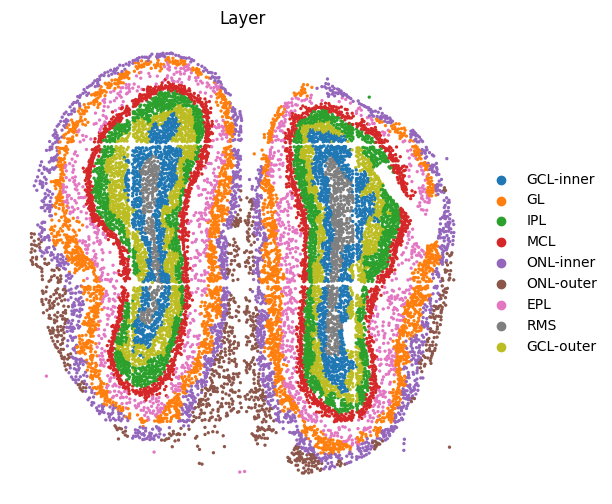

In [17]:
# annotation layers

replace_dict={'1.0':'GCL-inner', '2.0':'GL', '3.0':'IPL', 
              '4.0':'MCL', '5.0':'ONL-inner', '6.0':'ONL-outer', 
              '7.0':'EPL', '8.0':'RMS', '9.0':'GCL-outer'}
adata1.obs['Layer'] = adata1.obs['layer_cluster'].replace(replace_dict)

with rc_context({'figure.figsize': (6,6)}):
    sc.pl.embedding(adata1, basis="spatial", color=['Layer'],s=23, frameon=False)

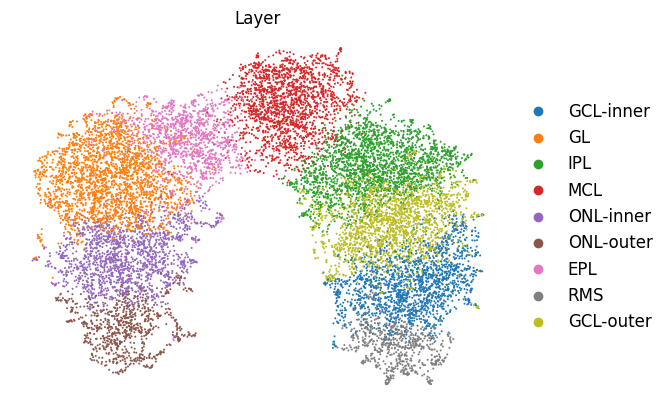

In [18]:
sc.pl.embedding(adata1, color='Layer', basis="umap_SE",
                frameon=False, wspace=0.4, vmax='p99',legend_fontsize=12)

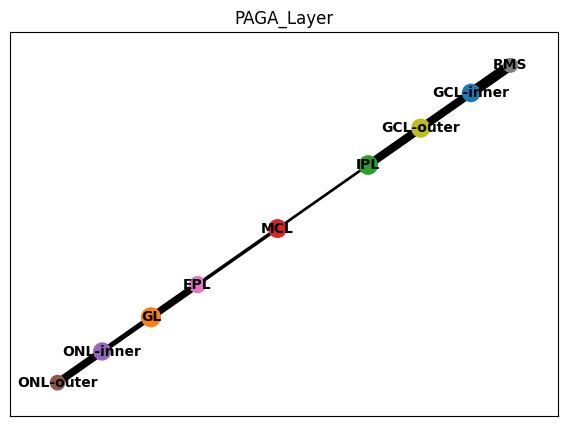

In [19]:
# PAGA

sc.pp.neighbors(adata1, use_rep='X_SE')
sc.tl.paga(adata1,groups='Layer')
sc.pl.paga(adata1,color=['Layer'], title=['PAGA_Layer'])

### Analysis of cell types

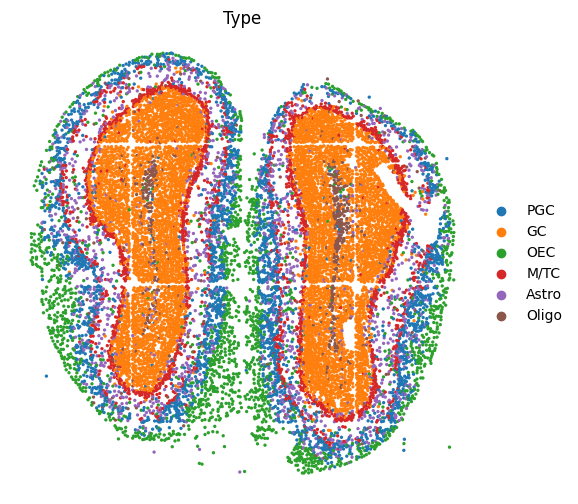

In [20]:
# Annotation of cell types
replace_dict={'0':'PGC', '1':'GC', '2':'GC', '3':'GC', 
              '4':'OEC', '5':'M/TC', '6':'Astro', '7':'Oligo', '8':'GC'}

adata1.obs['Type'] = adata1.obs['type_cluster'].replace(replace_dict)

with rc_context({'figure.figsize': (6,6)}):
    sc.pl.embedding(adata1, basis="spatial", color=['Type'],s=23, frameon=False)

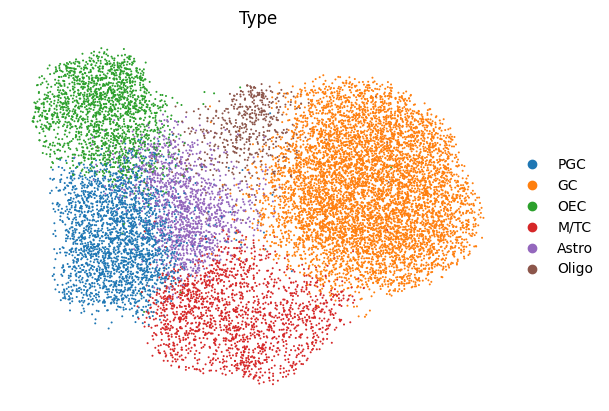

In [21]:
sc.pl.embedding(adata1, color='Type', basis="umap_CE", frameon=False, wspace=0.4)

### Relationship between them 

([<matplotlib.axis.XTick at 0x2b7437fa47f0>,
 [Text(0, 0, 'RMS'),
  Text(1, 0, 'GCL-inner'),
  Text(2, 0, 'GCL-outer'),
  Text(3, 0, 'IPL'),
  Text(4, 0, 'MCL'),
  Text(5, 0, 'EPL'),
  Text(6, 0, 'GL'),
  Text(7, 0, 'ONL-inner'),
  Text(8, 0, 'ONL-outer')])

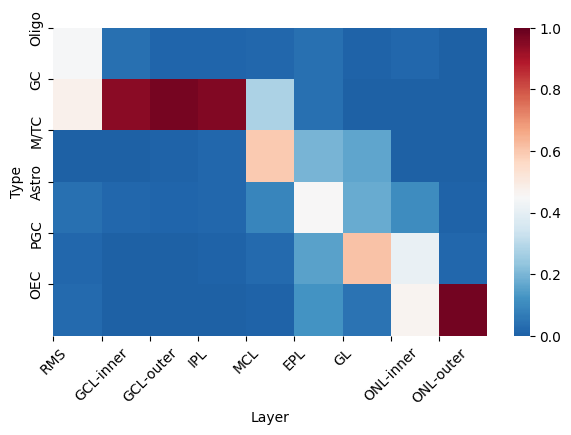

In [22]:
# confusion matrix
from sklearn.metrics import confusion_matrix
use = adata1.obs[['Type', 'Layer']]

use['value']=1
use_ = use.groupby(['Type', 'Layer'], as_index=False).sum()
plot_use = use_.pivot('Type','Layer')
plot_use.index = list(plot_use.index)
plot_use.columns = [ii[1] for ii in list(plot_use.columns)]
plot_use = plot_use.sort_index()
plot_use = plot_use/plot_use.sum()

plot_use.index
plot_use.columns
type_list = ['Oligo', 'GC', 'M/TC', 'Astro', 'PGC', 'OEC']
layer_list = ['RMS', 'GCL-inner', 'GCL-outer', 'IPL', 'MCL', 'EPL', 'GL', 'ONL-inner', 'ONL-outer']

import seaborn as sns
plt.figure(figsize=(7,4))
sns.heatmap(plot_use.loc[type_list,layer_list], cmap="RdBu_r", center=0.45, vmax=1) # 根据最下面的图按自己需求更改颜色
plt.ylabel('Type')
plt.xlabel('Layer')
plt.yticks(np.arange(6), type_list)
plt.xticks(np.arange(9), layer_list, rotation=45)

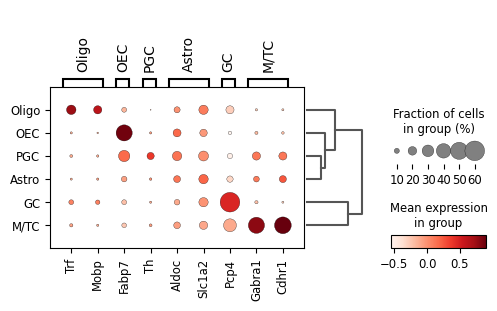

In [26]:
import pandas as pd
adata = sc.read('./data/olfactory_bulb.h5ad')
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=20)

adata.obs = adata1.obs
adata.obsm = adata1.obsm
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

marker_type = pd.read_csv('./data/ob_type_use.csv')
marker_type_dict = {ii:list(set(marker_type[ii].dropna().tolist()).intersection(adata.var_names)) for ii in marker_type.columns}

sc.tl.dendrogram(adata, groupby='Type', use_rep='X_CE')
sc.pl.dotplot(adata, marker_type_dict, groupby='Type', dendrogram=True, dot_max=0.6)